# QAOA Tutorial

#### Uncomment the cell below to pip install the necessary modules if not already installed

#### Note: Works with Qiskit Version 1.4.1 and Quantum Rings Qiskit Toolkit Version 0.1.10

In [1]:
# %pip install rustworkx
# %pip install numpy
# %pip install qiskit==1.4.1
# %pip install quantumrings-toolkit-qiskit==0.1.10
# %pip install matplotlib

#### Restart the kernel after installing any of the missing packages

### Quantum Approximate Optimization Algorithm (QAOA) - Max Cut

In this tutorial, we will introduce the Quantum Approximate Optimization Algorithm (QAOA) at a small scale and then see how we can scale it up using the qubits available through the Quantum Rings SDK. We will be applying the QAOA to the **Max-Cut** problem for a small graph which we will then scale up. This will be a dense tutorial so feel free to go at your own pace. 

The Quantum Approximate Optimization Algorithm (QAOA) is a hybrid (quantum-classical) iterative method for solving optimization problems. The hybrid aspect comes from the use of classical optimizers for the variational parameters of the algorithm which is then run through a quantum circuit. This will be expanded upon later. 

The **Max-Cut** problem is an optimization problem that is an [NP-hard class problem](https://en.wikipedia.org/wiki/NP-hardness) with numerous applications in clustering, network science, and statistical physics. This tutorial considers a graph of nodes connected by vertices, and aims to partition it into separate complementary sets. Put another way, the goal of this problem is to partition the nodes of a graph into two sets such that the number of edges traversed by this cut is maximized. An example of this is shown below and will be the small graph we construct for our initial introduction to this problem.

![Illustration of a max-cut problem](https://learning-api.quantum.ibm.com/assets/0de75f52-4873-4b5a-a0e9-a351dc48c910)

What this does is it takes the original graph and splits the vertices in to two subsets. We can represent this mathematically as the original graph being $G=\{V,E\}$ where the graph $G$ is a set of vertices $V$ and edges $E$. When we make the cut, we create two subsets of vertices that we can call $S$ and $T$. In the image above, if we start at the far left node and move clockwise numbering the vertices 0, 1, 2, 3, 4. When we make the cut we will have two groups. We can denote group 1 as $S$ and group 2 as $T$ so that $S=\{0, 2, 4\}$ and $T=\{1, 3\}$. There are five edges that are shared between these two groups, thus maximizing the "cut" that is made to form the groups, effectively maximizing the edges bridging the groups together. Note that if there were associated weights with the edges these would impact the grouping. For now we will just treat the weights for each edge as being equal to 1. However, in a real graph with real weights we would look for cuts that create the largest weight value between the two groups thus maximizing the weight.

### Small-scale QAOA

The QAOA is most often applied to combinatorial problems which are just a class of problems in mathematics and computer science that involve finding the optimal solution. We can represent the Max-Cut problem as a classical combinatorial optimization problem by first considering the minimization of a function $f(x)$.

$$
\min_{x\in \{0, 1\}^n}f(x)
$$

Where the input $x$ is a vector whose components correspond to each node of a graph. We can then constrain each of these components to be either 0 or 1 to represent being included or not included in the cut. This small-scale example case uses a graph with $n=5$ nodes.

We can write a function for a pair of nodes $i, j$ which indicates whether the corresponding edge $(i, j)$ is in the cut. For example, the function $x_i + x_j - 2x_ix_j$ is 1 only if one of either $x_i$ or $x_j$ are 1 meaning the edge is in the cut and zero otherwise. The problem of maximizing the edges in the cut can be formulated as 

$$
\max_{x\in \{0, 1\}^n} \sum_{(i,j)} x_i + x_j - 2 x_i x_j
$$

Which can be rewritten as a minimization of the form

$$
\min_{x\in \{0, 1\}^n} \sum_{(i,j)}  2 x_i x_j - x_i - x_j.
$$

The minimum of $f(x)$ in this case is when the number of edges traversed by the cut is maximal. Right now, there is nothing relating to quantum computing yet. We will reformulate this problem into something that a quantum computer can understand soon.

In [2]:
# where to find this example code?
# https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm

We will start with the initialization of the small graph discussed above. We generate a visualizaton of the graph using [rustworkx](https://www.rustworkx.org/). We give the graph 5 nodes and create it using the `edge_list` with each edge having a weight of `1.0`. The nodes are labeled as shown.

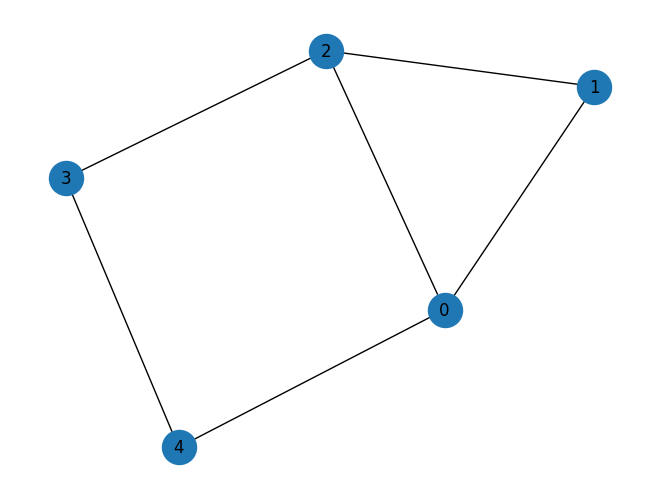

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

#### Map classical inputs to a quantum problem

The first thing we need to do is map the classical problem of a graph into quantum **circuits** and **operators**. To do this, there are three main steps to take:

1. Utilize a series of mathematical reformulations to represent this problem using the Quadratic Unconstrained Binary Optimization (QUBO) problems notation.
2. Rewrite the optimization problem as a Hamiltonian for which the ground state corresponds to the solution which minimizes the cost function
3. Create a quantum circuit which will prepare the ground state of this Hamiltonian via a process similar to quantum annealing.

> **Note:** In the QAOA methodology, you will have an operator (**Hamiltonian**) that represents the **cost function** of our hybrid algorithm as well as a parameterized (**Ansatz**) that represents quantum states with candidate solutions to the problem. You can sample from these candidate states and then evaluate them using the cost function.

**Graph** $\rightarrow$ **Optimization Problem**

The first step of mapping involves a notation change. The following expresses the problem in QUBO notation. You can find some info on [QUBO](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization) here if you want to know more.

$$
\min_{x\in \{0, 1\}^n}x^\top Q x
$$

Where $Q$ is a $n \times n$ matrix of real numbers. $n$ corresponds to the number of nodes in your graph, $x$ is the vector of binary variables introduced above, and $x^\top$ indicates the transpose of the vector $x$.

**Optimization problem** $\rightarrow$ **Hamiltonian**

Next, we reformulate the QUBO problem as a **Hamiltonian** matrix that represents the energy of a system:

$$
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
$$

>**Reformulation steps from the QAOA problem to the Hamiltonian**
>To rewrite the QAOA problem as a Hamiltonian, we first replace the binary variables $x_i$ with a new set of variables $z_i\in\{-1, 1\}$ via
$$
x_i=\frac{1-z_i}{2}
$$
>Here we can see that if $x_i$ is $0$ then $z_i$ must be $1$. When the $x_i$'s are substituted for the $z_i$'s in the optimization problem ($x^\top Qx$) an equivalent formulation can be obtained.
$$
 x^\top Qx=\sum_{ij}Q_{ij}x_ix_j \\ =\frac{1}{4}\sum_{ij}Q_{ij}(1-z_i)(1-z_j) \\=\frac{1}{4}\sum_{ij}Q_{ij}z_iz_j-\frac{1}{4}\sum_{ij}(Q_{ij}+Q_{ji})z_i + \frac{n^2}{4}.
$$
>If we define $b_i=-\sum_{j}(Q_{ij}+Q_{ji})$, then remove the prefactor of $1/4$ and drop the constant $n^2$, we arrive at the two equivalent formulations of the same optimization problem.
$$
\min_{x\in\{0,1\}^n} x^\top Qx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^\top Qz + b^\top z
$$
>We can drop these terms because they do not play a role in the optimization, leaving $b$ dependent only upon $Q$.
>
>To obtain a quantum formulation of the problem, we can consider the $z_i$ variables to be a Pauli-$Z$ matrix whose $2\times2$ form is as follows
$$
Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
$$
>
>When we substitute these matrices in the optimization problem above, we obtain the following Hamiltonian.
$$
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i
$$
>
>*Recall that the $Z$ matrices are embedded in the quantum computer's computational space, i.e., a Hilbert space of size $2^n \times 2^n$. Therefore, terms such as $Z_iZ_j$ are a tensor product $Z_i \otimes Z_j$ within the $2^n \times 2^n$ Hilbert space. For example, in a problem with five decision variables the term $Z_1Z_3$ is understood to mean $I \otimes Z_3 \otimes I \otimes Z_1 \otimes I$ where $I$ is the $2 \times 2$ identity matrix.*

This Hamiltonian is the **cost function Hamiltonian**. It has the property that its ground state corresponds to the solution that **minimizes the cost function** $f(x)$. Therefore, to solve the optimization problem, we now need to prepare the ground state of $H_c$ on the quantum computer. 

> **Note**: The prepared state does not need to be exactly ground state, but a state that has a high overlap with the ground state. The sampling from this state will yield the solution to $min f(x)$ with high probability.

The cell below creates the function to build the Pauli list from the group that can then be used to construct the cost function described.

In [3]:
from qiskit.quantum_info import SparsePauliOp

def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


**Hamiltonian** $\rightarrow$ **Quantum Circuit**

With the Hamiltonian $H_c$ we now have a quantum definition of the problem. We can now create a quantum circuit that will *sample* good solutions from the quantum computer. The QAOA is inspired by quantum annealing and applies alternating layers of operators in the quantum circuit. Feel free to check out more info on [Quantum Annealing](https://en.wikipedia.org/wiki/Quantum_annealing) if interested. 

The general idea behind building the quantum circuit is to take a known system that is set in the ground state and apply Hadamard gates across all the qubits, $H^{\otimes n}\ket{0}$, and then steer the system into the ground state of the cost operator that we are interested in. We can do this by applying two unitary operators of the form:

$$
U(\gamma_k, H_c) = e^{-i \gamma_k H_c}
$$
and
$$
U(\beta_k, H_m) = e^{-i \beta_k H_m}
$$

Where $\gamma_k$ and $\beta_k$ are the variational parameters which we will use the classical optimizer previously mentioned to find optimal values for and $H_c$ is our cost function. The $\gamma_k$ and $\beta_k$ are effectively phase angles for the operators. The $H_m$ term is known as a mixing function and takes the form of a series of Pauli-$X$ gates. This is represented as

$$
H_m = \sum_{j}X_j
$$

Each layer involves the application of the unitary operator for the cost function followed by the unitary operator for the mixing function. We can build up to $p$ layers by repeating this procedure as many times as desired. The quantum circuit that is generated is parameterized by $\gamma_i$ and $\beta_i$, which we will give an initial value to and then use the classical optimizer to tune. 

For this example we will use one QAOA layer that contains two parameters: $\gamma_0$ and $\beta_0$.

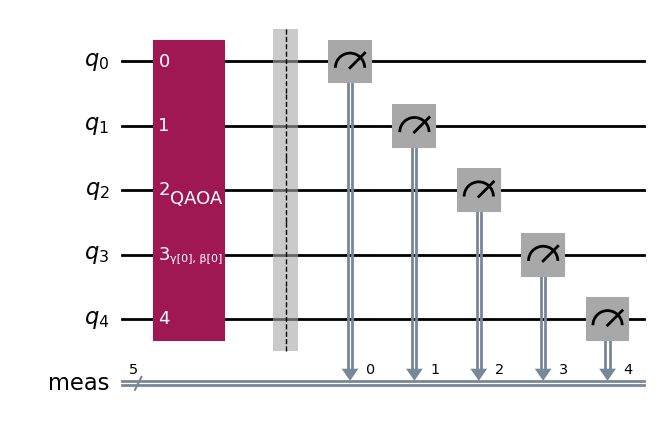

In [5]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=1)
circuit.measure_all()

circuit.draw('mpl')

In [6]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

#### Optimize the circuit for quantum hardware execution

> Note: You will need to have your Quantum Rings account saved locally to use the toolkit. If you have not saved your account locally please see check out [how to save a local account](https://portal.quantumrings.com/doc/Installation.html#saving-the-quantum-rings-account-locally).

The circuit above contains a series of abstractions that help to understand the quantum algorithms, but are not possible to run on the hardware. In order to run on a Quantum Processing Unit (QPU), the circuit needs to undergo a series of operations that make up the **transpilation** or **circuit optimization** step of the pattern. 

The Qiskit library offers a series of **transpilation passes** that cater to a wide range of circuit transformations. You need to make sure that your circuit is **optimized** for your purpose.

Transpilation may involve several steps:

- **Initial mapping** of the qubits in the circuit (such as decision variables) to physical qubits on the device.
- **Unrolling** of the instructions in the quantum circuit to the hardware-native instructions that the backend understands.
- **Routing** of any qubits in the circuit that interact to physical qubits that are adjacent with one another.
- **Error suppression** by adding single-qubit gates to suppress noise with dynamical decoupling.

The cell below transforms and optimizes the abstract circuit into a format that is ready for execution. We will use the Quantum Rings Backend from the Quantum Rings Qiskit Toolkit to run the circuit.

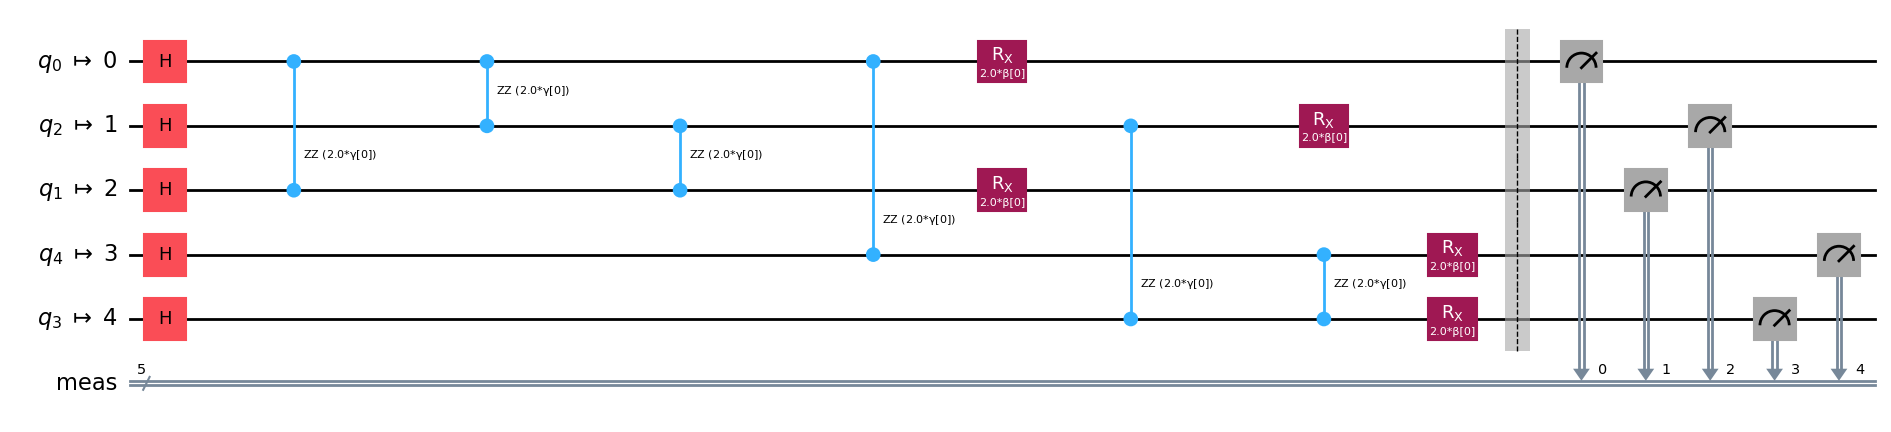

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import QuantumRingsLib
from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2

provider = QuantumRingsProvider()
backend = QrBackendV2(provider, num_qubits = 5)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

#### Execute using Qiskit primitives

Now that we have our circuit, we can start the QAOA workflow. The optimal QAOA parameters are found in an interative optimization loop which runs a series of circuit evaluations and uses a classical optimizer to find the optimal $\gamma_k$ and $\beta_k$ parameters. The execution loop has the following steps:

1. Define the initial parameters
2. Instantiate a new `Session` containing the optimization loop and the primitive used to sample the circuit
3. Once an optimal set of parameters is found, execute the circuit a final time to obtain a final distribution which will be used in the post-process step

**Define the circuit with initial parameters**

We start with arbitrary initial guesses for the chosen parameters. The values of $\gamma_k$ lie between $0$ and $2\pi$. For $\beta_k$ they are between $0$ and $\pi$. So we will initialize these to $\pi$ and $\pi/2$ respectively.

In [7]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]

**Define backend and execution primitive**

We will use the Quantum Rings Qiskit Toolkit `Estimator` for the measurement of the cost function since this is simply the expectation value of the cost function $\langle H_c \rangle$. The backend will be what we defined above using the toolkit and your local Quantum Rings account.

The `cost_func_estimator` is the function we will pass to our call for minimization. We will use `scipy.optimize`s built in `minimize` function and the `COBYLA` method for optimization. 

In [8]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

The `Session` from `qiskit_ibm_runtime` is an execution mode that is used to schedule workloads on quantum devices. Since the QAOA runs iteratively this works well with `Session`. A diagram with a quick overview of the difference in execution modes is shown below.

![Illustration showing the behavior of Single job, Batch, and Session runtime modes.](https://learning-api.quantum.ibm.com/assets/73e400b1-e5a9-4ee8-9842-3e2bbfbef3f5)


In [9]:
from qiskit_ibm_runtime import Session
from scipy.optimize import minimize

from quantumrings.toolkit.qiskit import QrEstimatorV2 as Estimator

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:

    estimator = Estimator(backend=backend)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.25706529969179
       x: [ 4.402e+00  3.219e-01]
    nfev: 23
   maxcv: 0.0


The optimizer was able to reduce the cost and find better parameters for the circuit. The result of the cost function with the new parameters is under the key `fun` and the new parameters are the `x` values.

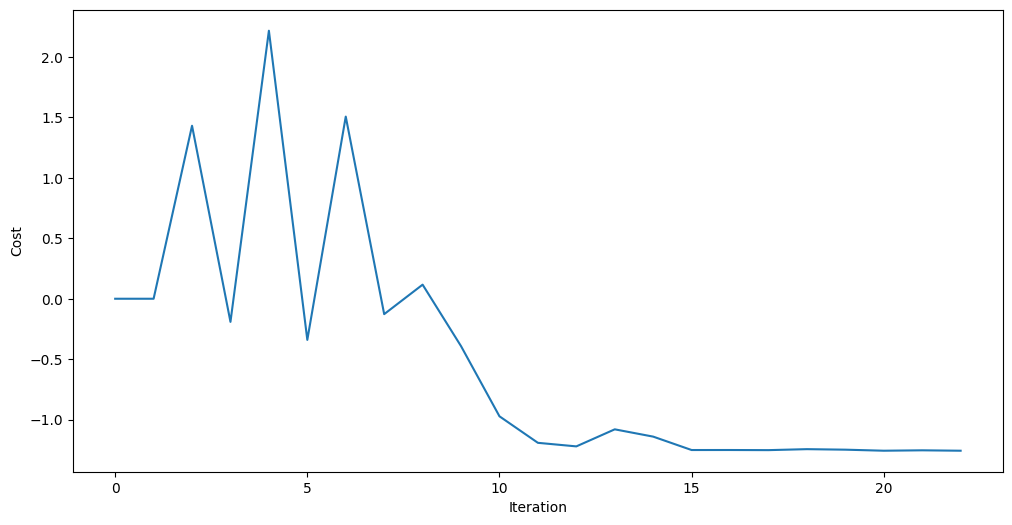

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Now that we have the optimal parameters for the circuit, we can assign these parameters and sample the final distribution obtained with the optimized parameters. This is where the *Sampler* primitive should be used since it is the probability distribution of bitstring measurements which correspond to the optimal cut of the graph

> **Note**: This means preparing a quantum state $\psi$ in the computer and then measuring it. A measurement will collapse the state into a single computational basis state - for example, `01010111000...` - which corresponds to a candidate solution $x$ to our initial optimization problem ($max f(x)$ or $min f(x)$ depending on the task).

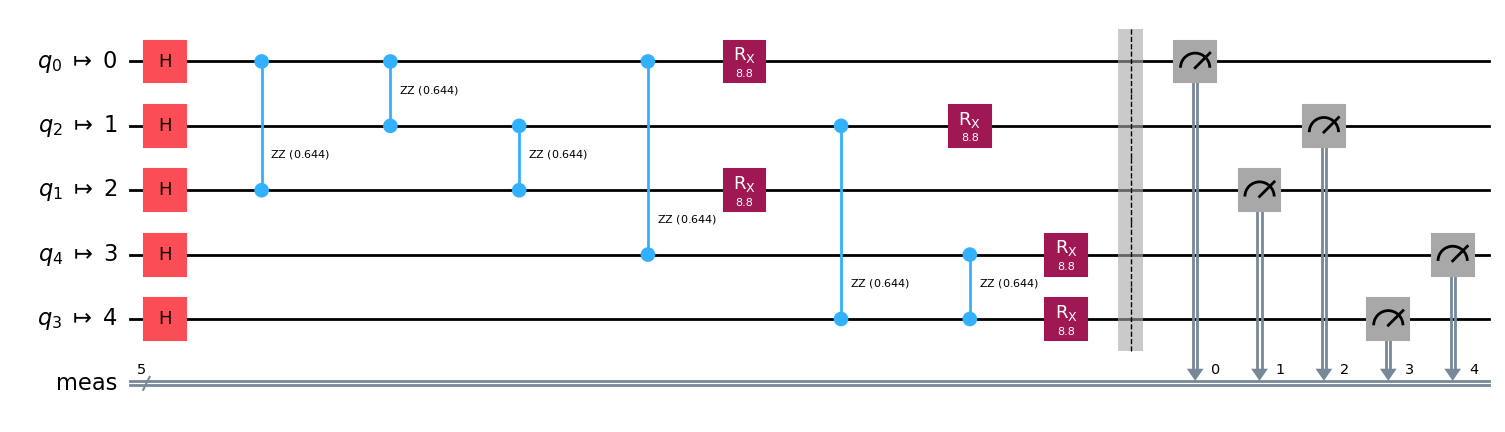

In [11]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

We will use the `Sampler` from the Quantum Rings Qiskit Toolkit to handle the sampling.

In [12]:
from quantumrings.toolkit.qiskit import QrSamplerV2 as Sampler

sampler = Sampler(backend=backend)

sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{0: 0.004, 1: 0.0093, 2: 0.0002, 3: 0.0205, 4: 0.0092, 5: 0.0667, 6: 0.0228, 7: 0.0062, 8: 0.0004, 9: 0.0967, 10: 0.0522, 11: 0.0999, 12: 0.034, 13: 0.0483, 14: 0.0287, 15: 0.0008, 16: 0.0005, 17: 0.0291, 18: 0.0488, 19: 0.0344, 20: 0.101, 21: 0.0488, 22: 0.0975, 23: 0.0007, 24: 0.008, 25: 0.0213, 26: 0.067, 27: 0.0092, 28: 0.0216, 29: 0.0004, 30: 0.0088, 31: 0.003}


#### Post-process: Return the result in classical format

The post-processing step interprets the sampling output to return a solution for our original problem. In this case, we are interested in the bitstring with the highest probability as this determines the optimal cut. The symmetries in the problem allow for four possible solutions, and the sampling process will return one of them with a slightly higher probability, but we will see in the plotted distribution below that four of the bistrings are significantly more likely than the rest.

In [13]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 0, 1, 0, 1]


/tmp/ipykernel_1792850/3823459478.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


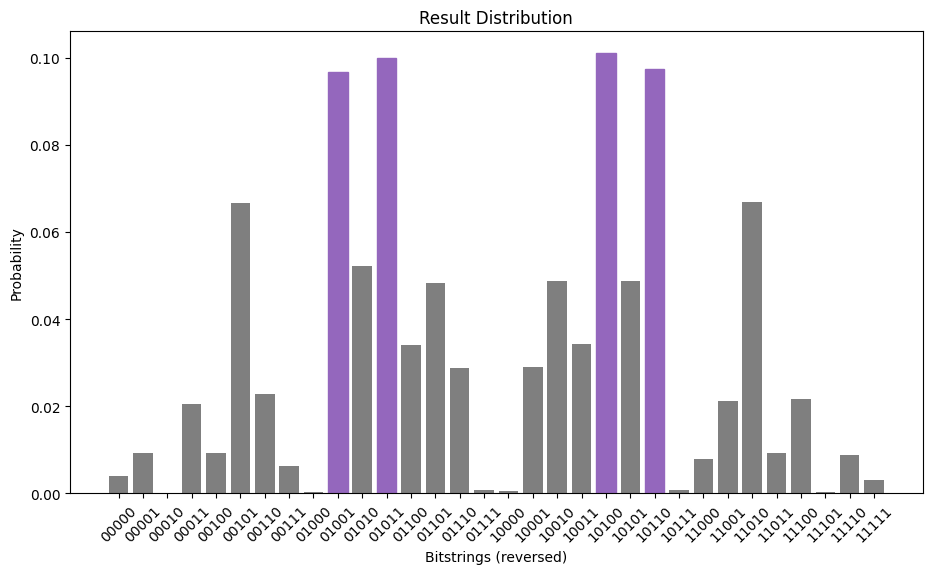

In [14]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

**Visualize best cut**

From the optimal bit string, we can visualize this cut on the original graph and calculate the value of the cut. In the plot below, the different colors for the vertices represent the two groups formed by the cut.

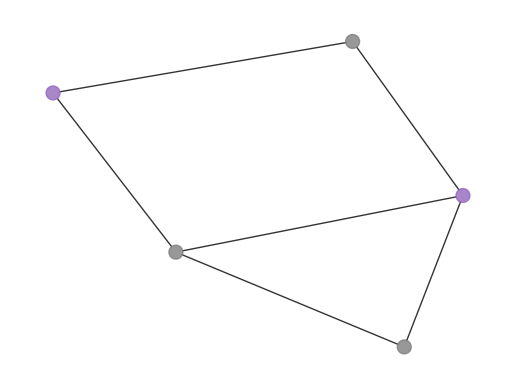

In [19]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [20]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 5


### Conclusion of Small-Scale

Congratulations! You have completed the small-scale optimization of the Max-Cut problem. While this was meant to be small-scale, the above code is able to be adjusted to run on graphs with a few more nodes than what we ran with some simple modifications. Below, we will go in to how to scale this up to be run with 100+ qubits using the Quantum Rings Simulator!

#### Scale it up!

Now let's scale up our graph! With IBMs Quantum Platform we can access their quantum computing qubit structure for the edge couplings as their hardware is connected in a heavy-hex lattice. For more info on that feel free to check out their [heavy-hex description](https://www.ibm.com/quantum/blog/heavy-hex-lattice).

However, we would like to use the Quantum Rings Toolkit to scale this up. Since the QR Toolkit is part of a simulator, it is able to use an all-to-all connection scheme. So we will define our qubit `edge_list` manually below as an all-to-all connectivity graph gets complex. Feel free to play with this list to see how the network changes!

In [21]:
edge_list = [[1, 0, 1.0], [4, 3, 1.0], [8, 7, 1.0], [11, 10, 1.0], [17, 12, 1.0], [19, 18, 1.0], [23, 22, 1.0], [25, 24, 1.0], 
             [26, 16, 1.0], [28, 27, 1.0], [30, 29, 1.0], [33, 20, 1.0], [36, 32, 1.0], [38, 37, 1.0], [40, 39, 1.0], [42, 41, 1.0], 
             [43, 34, 1.0], [47, 46, 1.0], [51, 50, 1.0], [54, 45, 1.0], [55, 49, 1.0], [56, 52, 1.0], [59, 58, 1.0], [61, 60, 1.0], 
             [65, 64, 1.0], [69, 68, 1.0], [72, 62, 1.0], [73, 66, 1.0], [90, 75, 1.0], [78, 77, 1.0], [81, 80, 1.0], [83, 82, 1.0], 
             [86, 85, 1.0], [93, 87, 1.0], [89, 88, 1.0], [91, 79, 1.0], [96, 95, 1.0], [98, 97, 1.0], [3, 2, 1.0], [15, 4, 1.0], 
             [6, 5, 1.0], [10, 9, 1.0], [12, 11, 1.0], [18, 14, 1.0], [16, 8, 1.0], [20, 19, 1.0], [22, 21, 1.0], [27, 26, 1.0], 
             [29, 28, 1.0], [31, 30, 1.0], [34, 24, 1.0], [47, 35, 1.0], [39, 38, 1.0], [41, 40, 1.0], [43, 42, 1.0], [45, 44, 1.0], 
             [49, 48, 1.0], [60, 53, 1.0], [64, 54, 1.0], [58, 57, 1.0], [63, 62, 1.0], [66, 65, 1.0], [68, 67, 1.0], [70, 69, 1.0], 
             [76, 75, 1.0], [77, 71, 1.0], [80, 79, 1.0], [82, 81, 1.0], [85, 84, 1.0], [88, 87, 1.0], [89, 74, 1.0], [98, 91, 1.0], 
             [92, 83, 1.0], [94, 90, 1.0], [14, 0, 1.0], [2, 1, 1.0], [5, 4, 1.0], [7, 6, 1.0], [9, 8, 1.0], [13, 12, 1.0], [30, 17, 1.0], 
             [21, 20, 1.0], [22, 15, 1.0], [24, 23, 1.0], [26, 25, 1.0], [32, 31, 1.0], [39, 33, 1.0], [35, 28, 1.0], [51, 36, 1.0], 
             [52, 37, 1.0], [44, 43, 1.0], [46, 45, 1.0], [48, 47, 1.0], [50, 49, 1.0], [53, 41, 1.0], [57, 56, 1.0], [71, 58, 1.0], 
             [60, 59, 1.0], [62, 61, 1.0], [64, 63, 1.0], [67, 66, 1.0], [68, 55, 1.0], [74, 70, 1.0], [81, 72, 1.0], [85, 73, 1.0], 
             [77, 76, 1.0], [79, 78, 1.0], [84, 83, 1.0], [87, 86, 1.0], [95, 94, 1.0], [97, 96, 1.0], [99, 98, 1.0]]

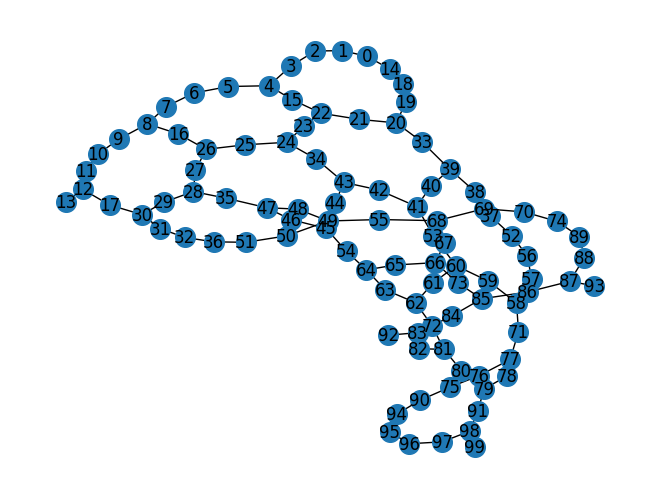

In [22]:
backend = QrBackendV2(provider, num_qubits=100)

n = 100  # Number of nodes in graph
graph_100 = rx.PyGraph()
graph_100.add_nodes_from(np.arange(0, n, 1))
elist = []

for edge in edge_list:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))
graph_100.add_edges_from(elist)
draw_graph(graph_100, node_size=200, with_labels=True, width=1)

#### Map classical inputs to a quantum problem

**Graph** $\rightarrow$ **Hamiltonian**

First, convert the graph you want to solve directly into a Hamiltonian that is suited for QAOA

In [23]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)

cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIII

**Hamiltonian** $\rightarrow$ **Quantum Circuit**

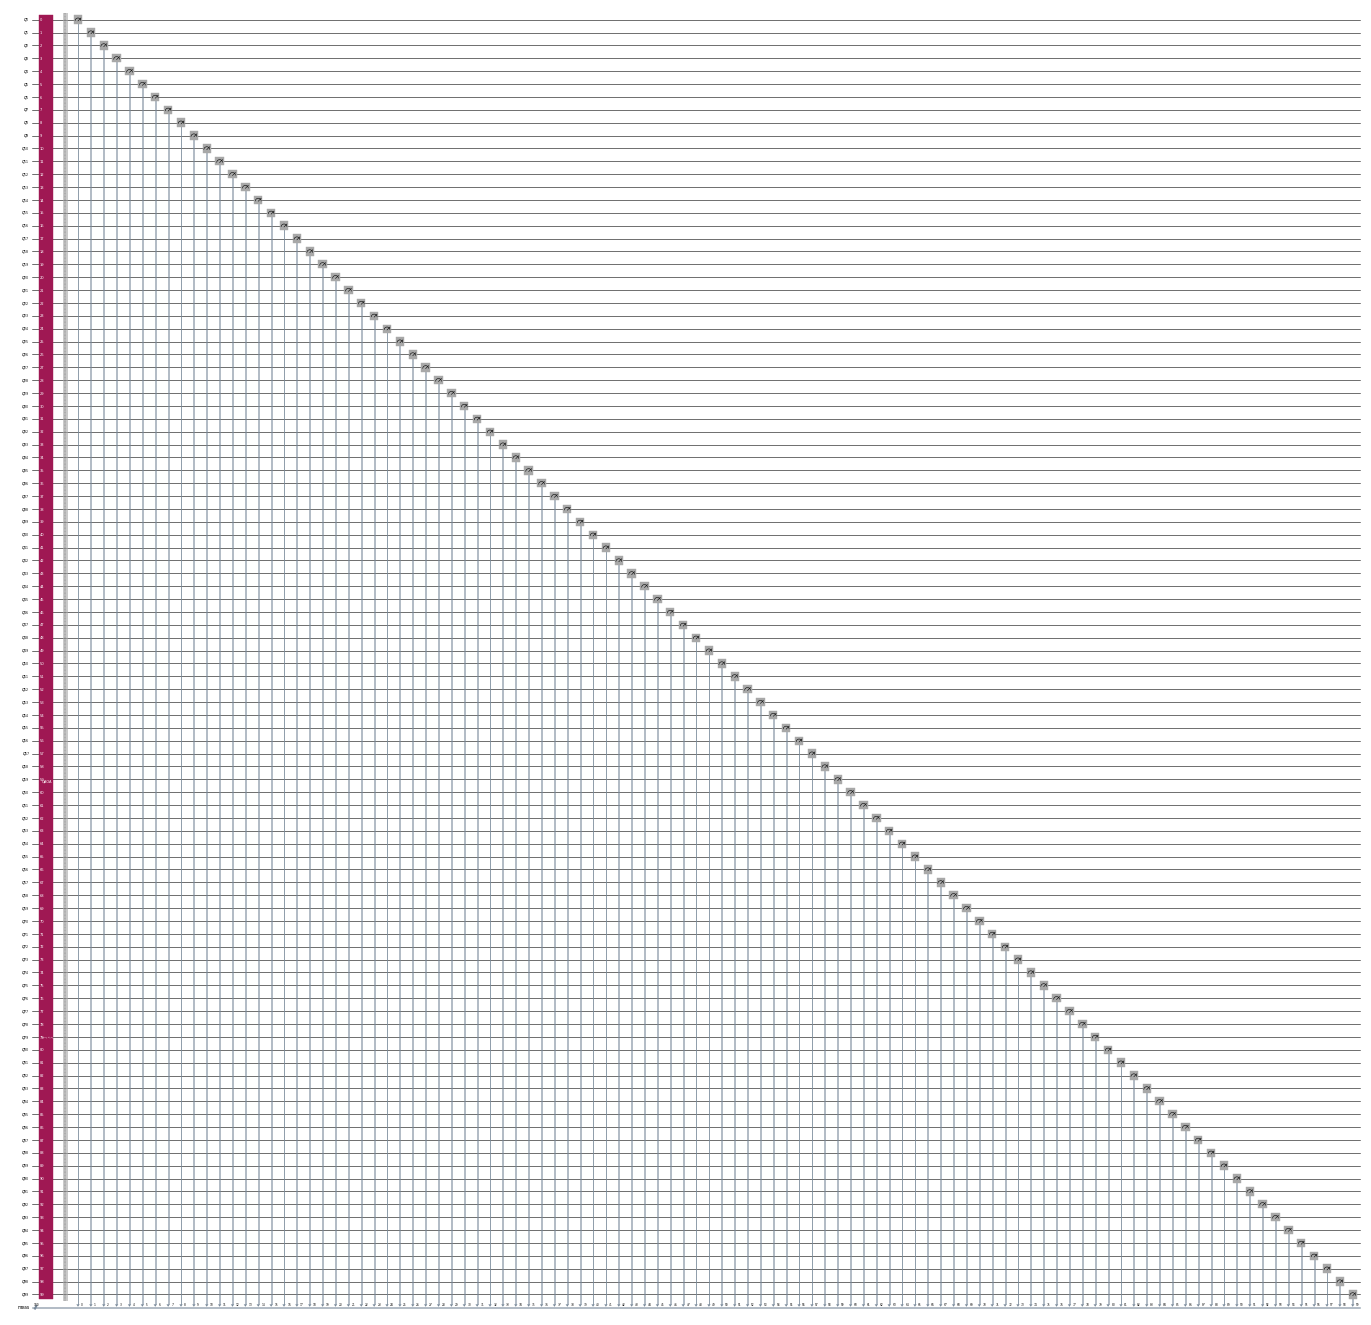

In [24]:
circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=1)
circuit_100.measure_all()

circuit_100.draw('mpl', fold=False, scale=0.2, idle_wires=False)

#### Optimize problem for quantum execution

To scale the circuit optimization step to utility-scale problems, you can take advantage of the high performance transpilation strategies introduced in Qiskit SDK v1.0. 

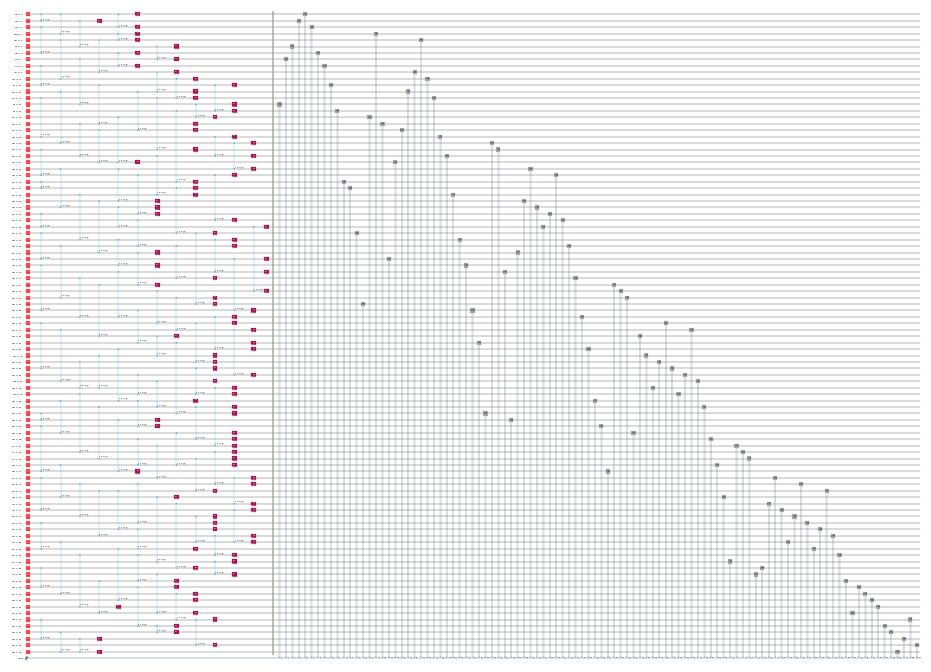

In [25]:
pm = generate_preset_pass_manager(optimization_level=3,
                                  backend=backend)

candidate_circuit_100 = pm.run(circuit_100)
candidate_circuit_100.draw('mpl', fold=False, scale=0.1, idle_wires=False)

### Execute using `Estimator`

To run QAOA, you must know the optimal parameters $\gamma_k$ and $\beta_k$ to put in the variational circuit. Optimize these parameters by running an optimization loop on the device. The cell submits jobs until the cost function value has converged and the optimal parameters for $\gamma_k$ and $\beta_k$ are determined. 

#### Find candidate solution by running the optimization on the device

First, run the optimization loop for the circuit parameters on a device.

In [26]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    estimator = Estimator(backend=backend)

    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit_100, cost_hamiltonian_100, estimator),
        method="COBYLA"
    )

    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.1228445858674236
       x: [ 4.390e+00  3.612e-01]
    nfev: 43
   maxcv: 0.0


Once the optimal parameters from running QAOA on the device have been found, assign the parameters to the circuit.

In [27]:
optimized_circuit_100 = candidate_circuit_100.assign_parameters(result.x)
optimized_circuit_100.draw('mpl', fold=False, idle_wires=False)

Finally, execute the circuit with the optimal parameters to sample from the corresponding distribution.

In [28]:
sampler = Sampler(backend=backend)
sampler.options.default_shots = 10000

sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit_100, )
job = sampler.run([pub], shots=int(1e4))

counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_100_int = {key: val/shots for key, val in counts_int.items()}

### Post-process: Return the result in the classical format

Check that the cost minimized in the optimization loop has converged to a certain value. The code below uses the parameters corresponding to the minimum value of the cost.

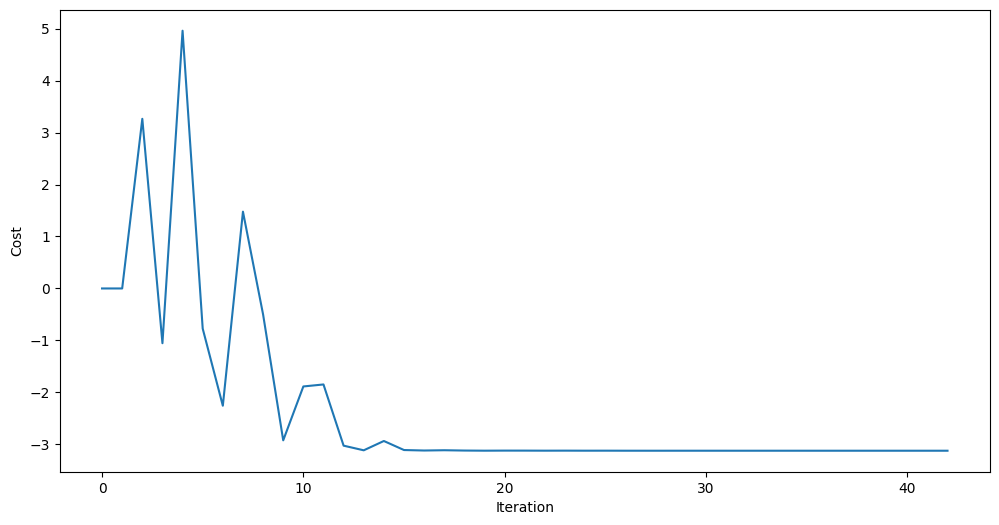

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Given that the likelihood of each solution is low, extract the solution that corresponds to the lowest cost.

In [30]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)

def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)

    return np.sum(observable.coeffs * _PARITY[reduced])

def best_solution(samples, hamiltonian):
    """Find solution with lowest cost"""
    min_cost = 1000
    min_sol = None
    for bit_str in samples.keys():
        # Qiskit uses little endian hence the [::-1]
        candidate_sol = int(bit_str)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        if fval <= min_cost:
            min_sol = candidate_sol

    return min_sol

best_sol_100 = best_solution(final_distribution_100_int, cost_hamiltonian_100)
best_sol_bitstring_100 = to_bitstring(int(best_sol_100), len(graph_100))
best_sol_bitstring_100.reverse()

print("Resulting bitstring:", best_sol_bitstring_100)

Resulting bitstring: [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Next, visualize the cut. Nodes of the same color belong to the same group as with the smaller graph before.

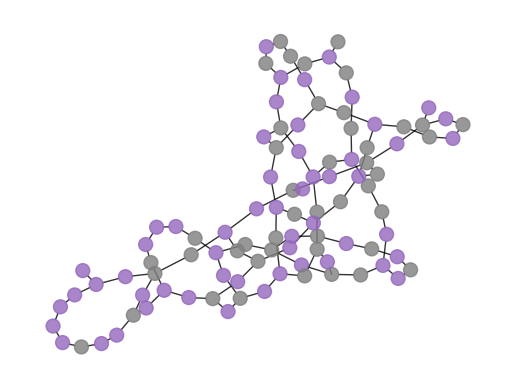

In [31]:
plot_result(graph_100, best_sol_bitstring_100)

Calculate the value of the cut.

In [32]:
cut_value_100 = evaluate_sample(best_sol_bitstring_100, graph_100)
print('The value of the cut is:', cut_value_100)

The value of the cut is: 81


Now compute the objective value of each sample that you measured on the quantum simulator. The sample with the lowest objective value is the solution returned by the simulation.

In [34]:
from collections import defaultdict

# auxiliary function to help plot cumulative distribution function
def _plot_cdf(objective_values: dict, ax, color):
    x_vals = sorted(objective_values.keys(), reverse=True)
    y_vals = np.cumsum([objective_values[x] for x in x_vals])
    ax.plot(x_vals, y_vals, color=color)

def plot_cdf(dist, ax, title):
    _plot_cdf(dist, ax, "C1")
    ax.vlines(min(list(dist.keys())), 0, 1, "C1", linestyle="--")

    ax.set_title(title)
    ax.set_xlabel("Objective function value")
    ax.set_ylabel("Cumulative distribution function")
    ax.grid(alpha=0.3)

# auxiliary function to convert bit-strings to objective values
def samples_to_objective_values(samples, hamiltonian):
    """Conver the samples to values of the objective function."""

    objective_values = defaultdict(float)
    for bit_str, prob in samples.items():
        candidate_sol = int(bit_str)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        objective_values[fval] += prob

    return objective_values

In [36]:
result_dist = samples_to_objective_values(final_distribution_100_int, cost_hamiltonian_100)

Finally, you can plot the cumulative distribution function to visualize how each sample contributes to the total probability distribution and the corresponding objective value. The horizontal spread shows the range of objective values of the samples in the final distribution. Ideally, you would see that the cumulative distribution function has "jumps" at the lower end of the objective function value axis. This would mean that few solutions with low cost have high probability of being sampled. A smooth, wide curve indicates that each sample is similarly likely, and they can have very different objective values, low or high.

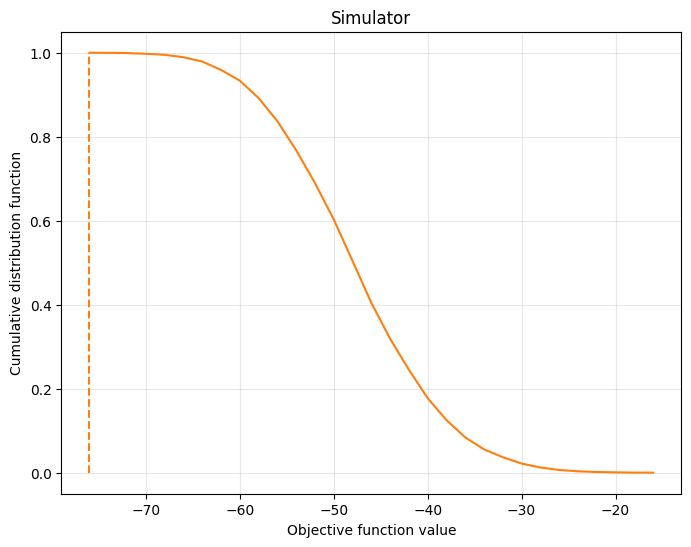

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_cdf(result_dist, ax, "Simulator")

### Conclusion

Congratulations! You have implemented a QAOA for the Max-Cut problem using the Quantum Rings simulator at both a small and large scale! In this notebook, we demonstrated how to solve an optimization problem using a quantum simulator from Quantum Rings. The demonstration included a utility-scale example, with circuit sizes that cannot be exactly simulated classically. Currently, quantum computers do not outperform classical computers for combinatorial optimization because of noise. However, the hardware is steadily improving, and new algorithms for quantum computers are continually being developed. Much of the research working on quantum heuristics for combinatorial optimization is tested with classical simulations that only allow for a small number of qubits, typically around 20 qubits. Now, with larger qubit counts and devices with less noise, researchers will be able to start benchmarking these quantum heursitics at large problem sizes on quantum hardware. One benefit of using the Quantum Rings simulation is that you are able to carry out calculations on a simulated network of 128 qubits! This is advantageous as it will make it easier to transfer over code that is developed in simulation when real quantum computers become accessible on a larger scale!